In [1]:
# In this example we'll split the data into a trianing set and a validation set
# so that we can see how different models perform and try to select the best one

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, feature_selection, linear_model

plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
# Load Data
train_df = pd.read_csv('train.csv')

#Select 70% for training and 30% for validation
n = round(len(train_df.index)*.7)
rows = np.random.choice(train_df.index.values, n)
train = train_df.ix[rows]
val = train_df.drop(rows)

In [4]:
# Get the y values from the training and validataiondata, drop Id and SalePrice columns
y_train = train['SalePrice']
X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_val = val['SalePrice']
X_val = val.drop(['Id', 'SalePrice'], axis=1)

In [5]:
# Get lists of continuous and categorical column names
cont = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat = X_train.select_dtypes(include=['object']).columns.tolist()

In [6]:
# Fill in all the categorical NaN values with 'None'. Looking at the documentation 
# there are some cases where NaN actually means that something is not present for 
# example, no pool. In other cases it seems like the value is unknown. It doesn't 
# make a difference to the analysis, though.

X_train[cat] = X_train[cat].fillna('None')
X_val[cat] = X_val[cat].fillna('None')

# Fill the missing continuous values with the median
# Maybe in some cases a missing value is meaningful, but we won't worry about that for now
X_train[cont] = X_train[cont].fillna(X_train[cont].median())

# Note that we're filling in the validation data with the median from the training set
# because this is what we'd do for a novel test case
X_val[cont] = X_val[cont].fillna(X_val[cont].median())

In [7]:
# Now let's center and scale the continuous variables, fit scaler with training data
scl = preprocessing.StandardScaler()
scl = scl.fit(X_train[cont])

X_train[cont] = scl.transform(X_train[cont])
X_val[cont] = scl.transform(X_val[cont])

In [8]:
# Make continuous variables into dummy variables
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)

In [9]:
# The DataFrame needs to have the same columns as the training data
diff = list(X_train.columns.difference(X_val.columns))
X_val = X_val.reindex(columns=list(X_val.columns.values) + diff)
diff2 = list(X_val.columns.difference(X_train.columns))
X_val = X_val.drop(diff2, axis=1)
X_val = X_val.fillna(0)

In [10]:
# First we'll try linear regression

<function matplotlib.pyplot.show>

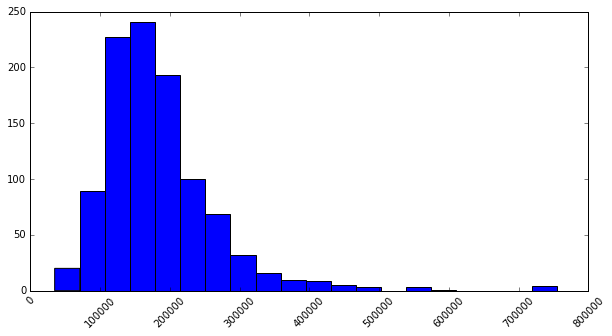

In [11]:
# Look at dependent variable of our training set, it's *not* normally distributed
# which is typical of house sale data, since there are a small number of homes that are very expensive
# but few homes that are close to $0 in price, and none that are negative in price
plt.hist(y_train, 20)
plt.xticks(rotation='45')
plt.show

<function matplotlib.pyplot.show>

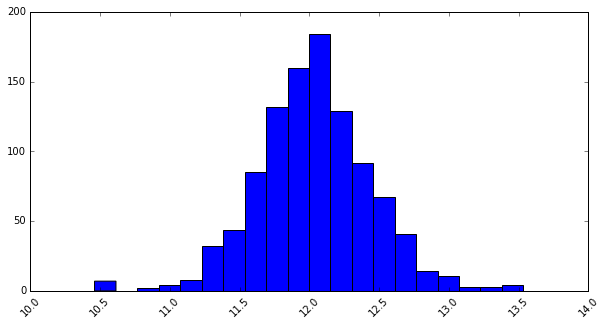

In [12]:
# It looks more normal if you take the natural log
plt.hist(np.log(y_train), 20)
plt.xticks(rotation='45')
plt.show

In [13]:
# Well use the natural log of sale price for our new DV since linear regression assumes normality
y_train = np.log(y_train)
y_val = np.log(y_val)

In [14]:
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(X_train, y_train)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_train, y_train))

Mean squared error: 0.01
Variance score: 0.95


In [15]:
# Predict
prediction = regr.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_val, y_val))

# We took the natural log earlier, so we need to convert predictions
prediction = np.exp(prediction)

Mean squared error: 8884824963420719104.00
Variance score: -56434641966299316224.00


In [16]:
# So that's terrible...
# I think the current model overfits the data since it is ok for the training but not so good for the validation set 
# we should use ridge regression instead since the L2 regularization should take care of this issue

In [17]:
# Create ridge regression object
a = (0.01, .1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0)
rr = linear_model.RidgeCV(alphas=a)

# Train the model using the training set
rr.fit(X_train, y_train)
print('alpha:', rr.alpha_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr.predict(X_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr.score(X_train, y_train))

alpha: 3.0
Mean squared error: 0.01
Variance score: 0.95


In [18]:
# Predict
prediction2 = rr.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr.score(X_val, y_val))

Mean squared error: 0.07
Variance score: 0.56


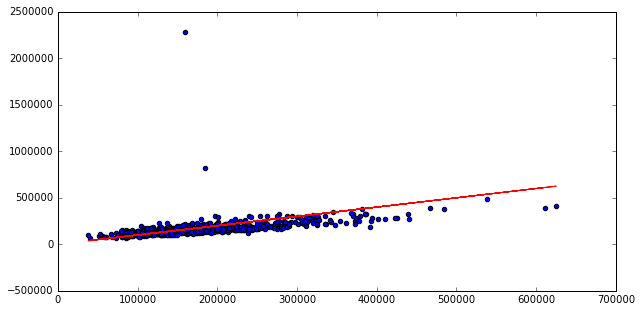

In [19]:
# Looking at the scatterplot I wonder if I did something wrong with the predictions but I don't know what
actual = val['SalePrice']
plt.scatter(actual, np.exp(prediction2))
plt.plot(actual, actual, 'r')

In [20]:
# Let's try again with fewer features

In [21]:
# This function allows us to try out a bunch of threshold values and see how they affect the R2

def compare_threshold(X_train, y_train, X_val, y_val):
    t_list = []
    score_train =[]
    score_val = []
    mse_train = []
    mse_val = []
    
    ridge = linear_model.RidgeCV(alphas=a)
    ridge.fit(X_train, y_train)
    
    for t in np.arange(0,.02,0.0005):
        # Play with the threshold value
        sfm = feature_selection.SelectFromModel(ridge, threshold=t)
        sfm.fit(X_train, y_train)
        selected = sfm.get_support()
        b = X_train.iloc[:,selected].columns.tolist()
        
        # Create linear regression object
        r = linear_model.RidgeCV()

        # Train the model using the training set
        r.fit(X_train[b], y_train)
        
        t_list.append(t)
        mse_train.append(np.mean((r.predict(X_train[b]) - y_train) ** 2))
        mse_val.append(np.mean((r.predict(X_val[b]) - y_val) ** 2))
        score_train.append(r.score(X_train[b], y_train))
        score_val.append(r.score(X_val[b], y_val))
        
        
    mse_df = pd.DataFrame({'Threshold': t_list, 'Training MSE': mse_train, 'Val MSE': mse_val})  
    R2_df = pd.DataFrame({'Threshold': t_list, 'Training R2': score_train, 'Val R2': score_val})
    
    return mse_df, R2_df

In [22]:
mse_df, R2_df = compare_threshold(X_train, y_train, X_val, y_val)

In [23]:
mse_df.head()

,Threshold,Training MSE,Val MSE
0,0.0000,0.008522,0.031382
1,0.0005,0.008523,0.031356
2,0.0010,0.008525,0.031338
3,0.0015,0.008537,0.031246
4,0.0020,0.008544,0.031244


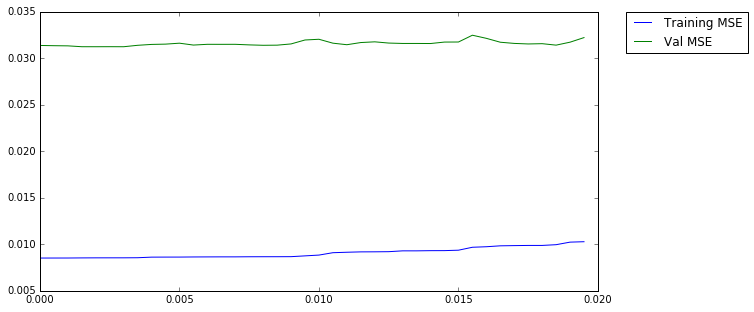

In [24]:
# MSE plot
plt.plot(mse_df['Threshold'],mse_df['Training MSE'])
plt.plot(mse_df['Threshold'],mse_df['Val MSE'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [25]:
R2_df.head()

,Threshold,Training R2,Val R2
0,0.0000,0.949742,0.800668
1,0.0005,0.949731,0.800835
2,0.0010,0.949719,0.800946
3,0.0015,0.949652,0.801535
4,0.0020,0.949610,0.801542


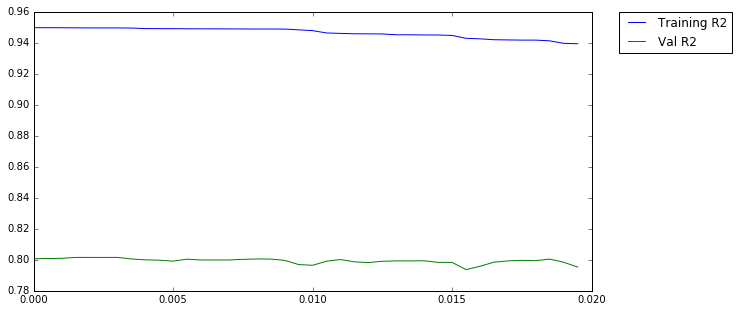

In [26]:
# R2 Plot
plt.plot(R2_df['Threshold'], R2_df['Training R2'])
plt.plot(R2_df['Threshold'],R2_df['Val R2'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [27]:
# We'll use the threshold obtained by looking at the graphs
ridge = linear_model.RidgeCV(alphas=a)
ridge.fit(X_train, y_train)

sfm = feature_selection.SelectFromModel(ridge, threshold=.008)
sfm.fit(X_train, y_train)
selected = sfm.get_support()
best = X_train.iloc[:,selected].columns.tolist()
len(best)

214

In [28]:
# Create linear regression object
rr2 = linear_model.RidgeCV(alphas=a)

# Train the model using the training set
rr2 = rr2.fit(X_train[best], y_train)
print('alpha:', rr2.alpha_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr2.predict(X_train[best]) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr2.score(X_train[best], y_train))

alpha: 2.0
Mean squared error: 0.01
Variance score: 0.95


In [29]:
# Predict
prediction3 = rr2.predict(X_val[best])

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr2.predict(X_val[best]) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr2.score(X_val[best], y_val))

Mean squared error: 0.03
Variance score: 0.81


In [30]:
# We took the natural log earlier, so we need to convert predictions
prediction3 = np.exp(prediction3)

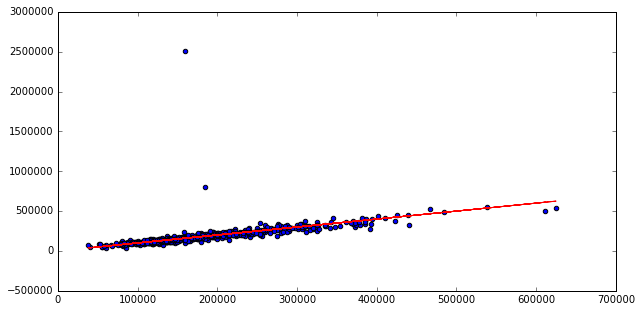

In [31]:
plt.scatter(actual, prediction3)
plt.plot(actual, actual, 'r')

In [32]:
# Now we need to create a model using all the training data

In [33]:
# Get X and y DFs
y = train['SalePrice']
X = train.drop(['Id', 'SalePrice'], axis=1)

# Fill missing values
X[cat] = X[cat].fillna('None')
X[cont] = X[cont].fillna(X[cont].median())

# Scale
scl = preprocessing.StandardScaler()
scl = scl.fit(X[cont])
X[cont] = scl.transform(X[cont])

# Dummy Variables
X = pd.get_dummies(X)

# Normalize DV
y = np.log(y)

In [34]:
# We'll use the same threshold as before to select features
ridge = linear_model.RidgeCV(alphas=a)
ridge.fit(X, y)

sfm = feature_selection.SelectFromModel(ridge, threshold=.0085)
sfm.fit(X, y)
selected = sfm.get_support()
best = X_train.iloc[:,selected].columns.tolist()
len(best)

213

In [35]:
# Create linear regression object
rr = linear_model.RidgeCV(alphas=a)

# Train the model using the training set
rr = rr.fit(X[best], y)
print('alpha:', rr.alpha_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr.predict(X[best]) - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr.score(X[best], y))

alpha: 2.0
Mean squared error: 0.01
Variance score: 0.95


In [36]:
# Load test data
test_df = pd.read_csv('test.csv')

# Test X data
test_id = test_df['Id'].values
X_test = test_df.drop(['Id'], axis=1)

# Fill missing values
X_test[cat] = X_test[cat].fillna('None')
X_test[cont] = X_test[cont].fillna(X[cont].median())

# Scale
X_test[cont] = scl.transform(X_test[cont])

# Dummy Variables
X_test = pd.get_dummies(X_test)

# The test DataFrame needs to have the same columns as the training data
diff = list(X.columns.difference(X_test.columns))
X_test = X_test.reindex(columns=list(X_test.columns.values) + diff)
diff2 = list(X_test.columns.difference(X.columns))
X_test = X_test.drop(diff2, axis=1)
X_test = X_test.fillna(0)

In [37]:
# Predict
y_pred = rr.predict(X_test[best])
y_pred = np.exp(y_pred)

# DataFrame of Id and Predictions
pred_df = pd.DataFrame(data={'Id': test_id, 'SalePrice': y_pred})

# Save solution file
pred_df.to_csv('solution_ridge1.csv', index=False)

In [38]:
# These preditions contain negative values 
pred_df.describe()

,Id,SalePrice
count,1459.000000,1.459000e+03
mean,2190.000000,1.735724e+05
std,421.321334,9.125991e+04
min,1461.000000,9.785753e+03
25%,1825.500000,1.232760e+05
50%,2190.000000,1.562045e+05
75%,2554.500000,2.069136e+05
max,2919.000000,1.603714e+06


In [39]:
# Create linear regression object
rr = linear_model.Ridge()

# Train the model using the training set
rr = rr.fit(X_train, y)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr.predict(X_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr.score(X_train, y_train))

Mean squared error: 0.01
Variance score: 0.95


In [40]:
# Predict
prediction = rr.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((rr.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % rr.score(X_val, y_val))

Mean squared error: 0.10
Variance score: 0.40


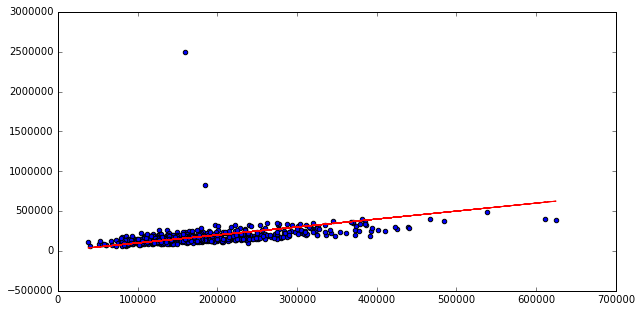

In [41]:
plt.scatter(actual, np.exp(prediction))
plt.plot(actual, actual, 'r')

In [42]:
# Seeing how lasso does

In [55]:
# This function allows us to try out a bunch of alpha values and see how they affect the R2

def compare_alpha(X_train, y_train, X_val, y_val):
    alpha_list = []
    score_train =[]
    score_val = []
    mse_train = []
    mse_val = []
    
    for a in np.arange(0.0005,.01,0.0005):
        # Create linear regression object
        r = linear_model.Lasso(alpha=a)

        # Train the model using the training set
        r.fit(X_train, y_train)
        
        alpha_list.append(a)
        mse_train.append(np.mean((r.predict(X_train) - y_train) ** 2))
        mse_val.append(np.mean((r.predict(X_val) - y_val) ** 2))
        score_train.append(r.score(X_train, y_train))
        score_val.append(r.score(X_val, y_val))
        
        
    mse_df = pd.DataFrame({'Alpha': alpha_list, 'Training MSE': mse_train, 'Val MSE': mse_val})  
    R2_df = pd.DataFrame({'Alpha': alpha_list, 'Training R2': score_train, 'Val R2': score_val})
    
    return mse_df, R2_df

In [56]:
mse_df, R2_df = compare_alpha(X_train, y_train, X_val, y_val)

In [57]:
mse_df.head()

,Alpha,Training MSE,Val MSE
0,0.0005,0.010794,0.049532
1,0.0010,0.012327,0.056562
2,0.0015,0.013300,0.047239
3,0.0020,0.014274,0.041871
4,0.0025,0.015397,0.038337


In [58]:
R2_df.head()

,Alpha,Training R2,Val R2
0,0.0005,0.936340,0.685385
1,0.0010,0.927301,0.640731
2,0.0015,0.921560,0.699950
3,0.0020,0.915818,0.734044
4,0.0025,0.909189,0.756493


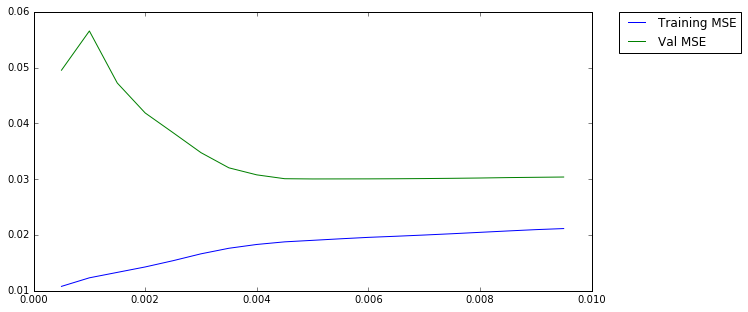

In [59]:
# MSE plot
plt.plot(mse_df['Alpha'],mse_df['Training MSE'])
plt.plot(mse_df['Alpha'],mse_df['Val MSE'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

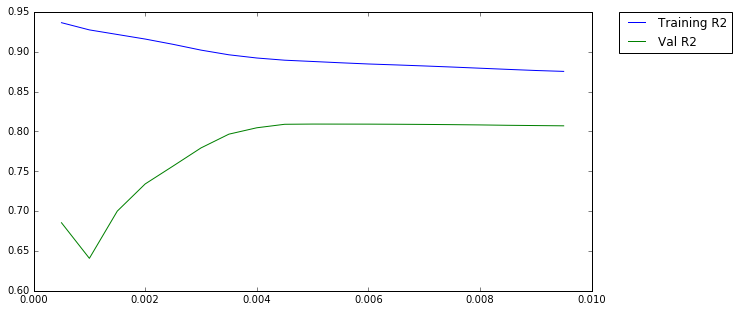

In [60]:
# R2 Plot
plt.plot(R2_df['Alpha'], R2_df['Training R2'])
plt.plot(R2_df['Alpha'],R2_df['Val R2'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [61]:
lasso = linear_model.Lasso(alpha=0.005)
lasso.fit(X_train, y_train)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lasso.predict(X_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lasso.score(X_train, y_train))

Mean squared error: 0.02
Variance score: 0.89


In [62]:
# Test
prediction_l = lasso.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lasso.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lasso.score(X_val, y_val))

Mean squared error: 0.03
Variance score: 0.81


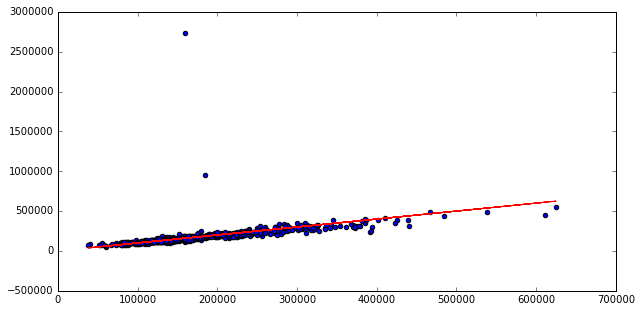

In [63]:
prediction_l = np.exp(prediction_l)
plt.scatter(actual, prediction_l)
plt.plot(actual, actual, 'r')

In [64]:
lasso2 = linear_model.LassoCV()
lasso2.fit(X_train, y_train)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lasso2.predict(X_train) - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lasso2.score(X_train, y_train))

Mean squared error: 0.01
Variance score: 0.94


In [65]:
# Test
prediction_l2 = lasso2.predict(X_val)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((lasso2.predict(X_val) - y_val) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lasso2.score(X_val, y_val))

Mean squared error: 0.05
Variance score: 0.70


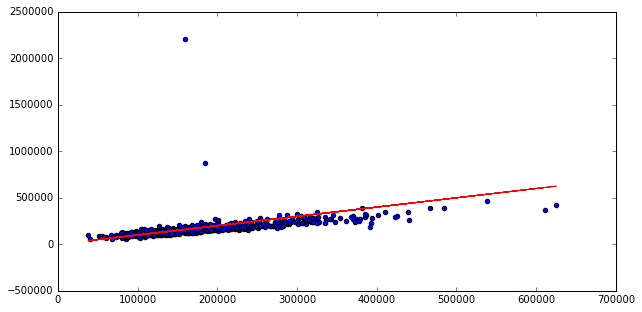

In [66]:
prediction_l2 = np.exp(prediction_l2)
plt.scatter(actual, prediction_l2)
plt.plot(actual, actual, 'r')